Loading data/SR2021.csv
Loading data/SR2022.csv
Loading data/SR2023.csv
Loading data/SR2024.csv
Seasons included in data: {'Fall 2021', 'Spring 2024', 'Winter 2023', 'Summer 2021', 'Spring 2023', 'Summer 2023', 'Spring 2022', 'Summer 2022', 'Winter 2024', 'Fall 2024', 'Fall 2023', 'Fall 2022', 'Summer 2024', 'Spring 2021', 'Winter 2022', 'Winter 2021'}


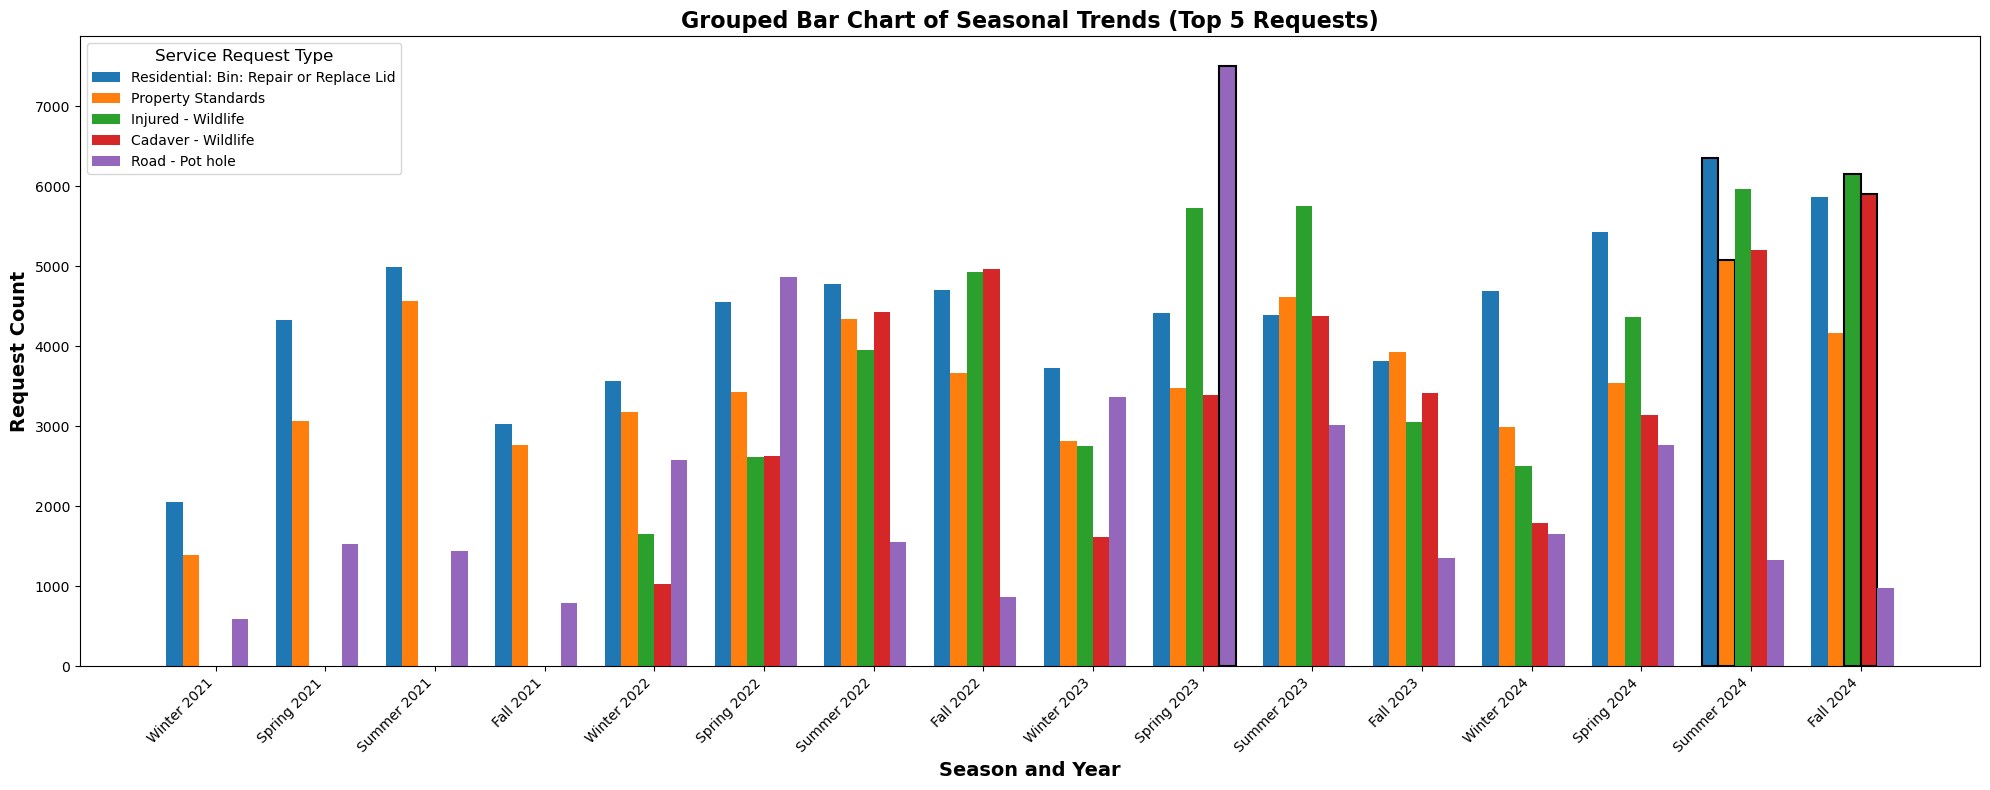

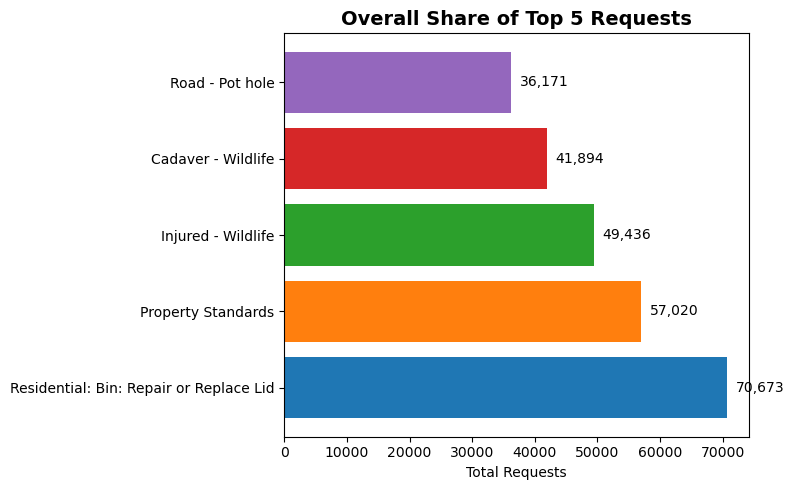

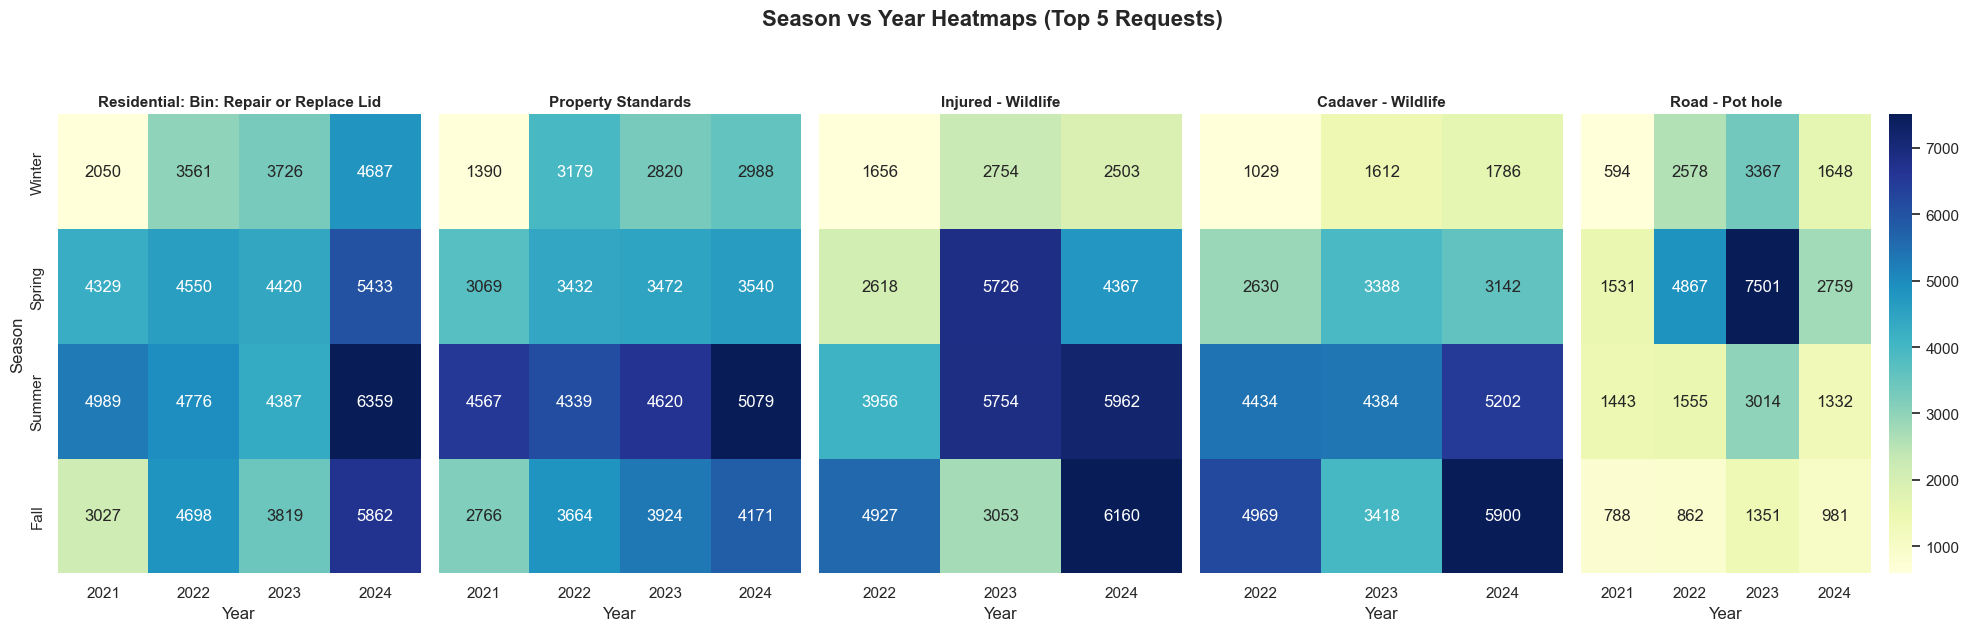

In [1]:

# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. LOAD AND MERGE DATA

paths = [
    "data/SR2021.csv",
    "data/SR2022.csv",
    "data/SR2023.csv",
    "data/SR2024.csv"
]

frames = []
for p in paths:
    try:
        print(f"Loading {p}")
        frames.append(pd.read_csv(p, on_bad_lines='skip'))
    except Exception as e:
        print(f"Error loading {p}: {e}")

df = pd.concat(frames, ignore_index=True)


# 3. CLEAN DATA

# Convert dates
df['Creation Date'] = pd.to_datetime(df['Creation Date'], errors='coerce')
df = df.dropna(subset=['Creation Date','Service Request Type'])

# Create Year and Month
df['Year'] = df['Creation Date'].dt.year
df['Month'] = df['Creation Date'].dt.month

# Map month to season
def get_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Combine Season and Year
df['SeasonYear'] = df['Season'] + " " + df['Year'].astype(str)

# For chronological sorting
def season_num(m):
    if m in [12,1,2]: return 1
    elif m in [3,4,5]: return 2
    elif m in [6,7,8]: return 3
    else: return 4

df['SeasonNum'] = df['Month'].apply(season_num)
df['SeasonYearSort'] = df['Year']*10 + df['SeasonNum']

# 4. FILTER TO TOP 5 SERVICE REQUEST TYPES

top5 = df['Service Request Type'].value_counts().head(5).index.tolist()
filtered = df[df['Service Request Type'].isin(top5)]

# 5. GROUP BY SEASON-YEAR

trend_season = (
    filtered.groupby(['SeasonYear','SeasonYearSort','Service Request Type'])
    .size()
    .reset_index(name='Count')
    .sort_values('SeasonYearSort')
)

# Pivot to wide format
pivot_season = trend_season.pivot_table(
    index=['SeasonYear','SeasonYearSort'],
    columns='Service Request Type',
    values='Count',
    fill_value=0
).sort_index(level=1)

# Sort the index properly
pivot_season = pivot_season.sort_index(level=1)
x_labels = pivot_season.index.get_level_values(0).tolist()

print("Seasons included in data:", set(x_labels))


# 6. GROUPED BAR CHART (Season-Year Trends)

colors = plt.get_cmap('tab10').colors
color_map = {req: colors[i % len(colors)] for i, req in enumerate(top5)}

x = np.arange(len(x_labels))
bar_width = 0.15

plt.figure(figsize=(20,8))
for i, req in enumerate(top5):
    series = pivot_season[req]
    plt.bar(x + i*bar_width, series.values, width=bar_width,
            color=color_map[req], label=req)
    # Highlight the peak with border
    peak_idx = series.values.argmax()
    plt.bar(x[peak_idx] + i*bar_width, series.values[peak_idx],
            width=bar_width, color=color_map[req], edgecolor='black', linewidth=1.5)

plt.xticks(x + bar_width*(len(top5)/2), x_labels, rotation=45, ha='right')
plt.xlabel("Season and Year", fontsize=14, fontweight='bold')
plt.ylabel("Request Count", fontsize=14, fontweight='bold')
plt.title("Grouped Bar Chart of Seasonal Trends (Top 5 Requests)", fontsize=16, fontweight='bold')
plt.legend(title="Service Request Type", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.savefig("seasonal_trends_grouped_bar.png", dpi=300)
plt.show()


# 7. OTHER VISUALIZATIONS

# Horizontal Bar
overall = filtered['Service Request Type'].value_counts().loc[top5]
plt.figure(figsize=(8,5))
bars = plt.barh(overall.index, overall.values, color=[color_map[r] for r in overall.index])
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(overall.values)*0.02,
             bar.get_y() + bar.get_height()/2,
             f"{width:,}", va='center', fontsize=10)
plt.title("Overall Share of Top 5 Requests", fontsize=14, fontweight='bold')
plt.xlabel("Total Requests")
plt.tight_layout()
plt.savefig("horizontal_bar_overall.png", dpi=300)
plt.show()

# Heatmaps
heat_data = (
    filtered.groupby(['Year','Season','Service Request Type'])
    .size()
    .reset_index(name='Count')
)

season_order = ['Winter','Spring','Summer','Fall']
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, len(top5), figsize=(4*len(top5), 6), sharey=True)

for i, req in enumerate(top5):
    ax = axes[i]
    hdata = heat_data[heat_data['Service Request Type']==req]
    hpivot = hdata.pivot_table(index='Season', columns='Year', values='Count', fill_value=0)
    hpivot = hpivot.reindex(season_order)
    hpivot = hpivot.astype(int)  # ensure integers
    sns.heatmap(hpivot, annot=True, fmt='d', cmap='YlGnBu', cbar=(i==len(top5)-1), ax=ax)
    ax.set_title(req, fontsize=11, fontweight='bold')
    ax.set_xlabel("Year")
    if i == 0:
        ax.set_ylabel("Season")
    else:
        ax.set_ylabel("")

fig.suptitle("Season vs Year Heatmaps (Top 5 Requests)", fontsize=16, fontweight='bold', y=1.05)
fig.tight_layout()
fig.savefig("heatmaps_top5.png", dpi=300, bbox_inches='tight')
plt.show()